# Init

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torchvision import datasets
from torchvision import transforms as T
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Get device for torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# Dataset

Loading data using Yahoo Finance module

In [3]:
# List of stocks to analyze
GOOG = 'GOOG'
MSFT = 'MSFT'
AMZN = 'AMZN'
META = 'META'
stock_list = [GOOG, MSFT, AMZN, META]
stock_company_map = {
    GOOG: 'Google',
    MSFT: 'Microsoft',
    AMZN: 'Amazon',
    META: 'Meta'
}

In [4]:
# Time range - last 5 year of data
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

In [5]:
# Download data
stock_data = {}
for stock in stock_list:
    stock_data[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
# Add company name to dataframes
for stock in stock_list:
    stock_data[stock]['Company'] = stock_company_map[stock]

In [7]:
# Stack dataframes
df = pd.concat(stock_data.values(), axis=0)

In [8]:
# Check dataframe
df.sample(5)

,Open,High,Low,Close,Adj Close,Volume,Company
Date,,,,,,,
2021-07-15,349.230011,349.230011,340.220001,344.459991,344.459991,14781600,Meta
2023-07-05,120.059998,123.370003,120.059998,122.629997,122.629997,17830300,Google
2020-06-03,232.110001,232.649994,228.529999,230.160004,230.160004,15380300,Meta
2020-10-01,160.399994,161.199997,158.600006,161.063004,161.063004,99438000,Amazon
2022-06-16,108.149498,109.290497,105.792503,106.636002,106.636002,35314000,Google


# EDA

#### Basic stats

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5028 entries, 2018-11-15 to 2023-11-14
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5028 non-null   float64
 1   High       5028 non-null   float64
 2   Low        5028 non-null   float64
 3   Close      5028 non-null   float64
 4   Adj Close  5028 non-null   float64
 5   Volume     5028 non-null   int64  
 6   Company    5028 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 314.2+ KB


#### Closing Price Plots

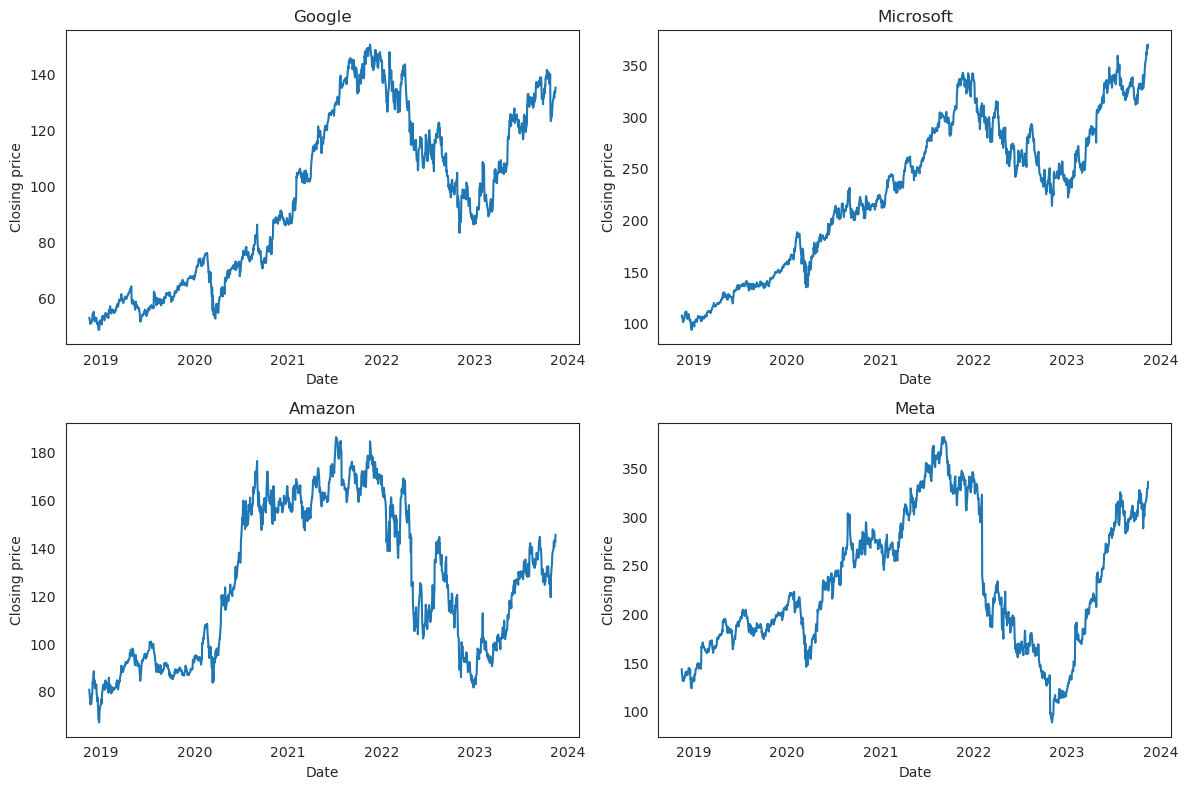

In [10]:
# Plot closing price for all companies
sns.set_style('white')
fig, axes = plt.subplots(2,2,figsize=(12, 8))
for i, stock in enumerate(stock_list):
    ax = axes[i//2, i%2]
    sns.lineplot(stock_data[stock]['Close'], ax=ax)
    ax.set_title(stock_company_map[stock])
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing price')
plt.tight_layout()
plt.show()

# Model

In [11]:
# Model class
class StockLSTM(nn.Module):

    # Constructor
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()

        # Define params
        self.output_size = output_size
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Define fully connected layers
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc_2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    # Forward method
    def forward(self, input):

        # LSTM
        h0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers, input.size(0), self.hidden_size).to(device).requires_grad_()
        output, (hn, cn) = self.lstm(input, (h0.detach(), c0.detach()))
        
        # FC layers
        output = self.fc_1(output[:,-1,:])
        output = self.relu(output)
        output = self.fc_2(output)

        # Return output
        return output

In [135]:
# Training function
def train_model(model, optimizer, criterion, epochs, data, **options):

    # Initialize data
    initial_epoch = options['initial_epoch'] if 'initial_epoch' in options else 0
    epochs_d = len(str(epochs))

    # Run epochs
    for epoch in range(initial_epoch, epochs):

        # Move data to device
        X_train, X_test, y_train, y_test = data
        X_train, y_train = torch.from_numpy(X_train).to(device), torch.from_numpy(y_train).to(device)
        
        # Calculate output
        outputs = model.forward(X_train)
        
        # Calculate loss and optimize
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Log epoch stats
        if(epoch%100 == 0):
            print(f'Epoch {epoch:>{epochs_d}d}/{epochs} - loss:{loss.item():>7f}')

    # Final print for last epoch
    print(f'Epoch {(epoch+1):>{epochs_d}d}/{epochs} - loss:{loss.item():>7f}')

# Training

#### Setup data for training

In [13]:
# Get count of data
df.groupby('Company').count()

,Open,High,Low,Close,Adj Close,Volume
Company,,,,,,
Amazon,1257,1257,1257,1257,1257,1257
Google,1257,1257,1257,1257,1257,1257
Meta,1257,1257,1257,1257,1257,1257
Microsoft,1257,1257,1257,1257,1257,1257


In [14]:
# Create train data given the data and sequence length
def generate_train_data(data, seq_length, train_size):

    # Create all possible sequences of data
    seq_data = []
    for i in range(len(data) - seq_length):
        seq_data.append(data[i:i+seq_length])
    seq_data = np.array(seq_data, dtype=np.float32)

    # Split train/test
    x_train = seq_data[:train_size,:-1,:]
    y_train = seq_data[:train_size,-1,:]
    x_test = seq_data[train_size:,:-1]
    y_test = seq_data[train_size:,-1,:]

    # Return data
    return x_train, x_test, y_train, y_test

In [15]:
# Map containing data for different stocks
datasets = {}
scalers = {}

# Look back and training lengths
n_train = 1000
look_back = 50

# Create train/test data for all the stocks
close_price_col_name = 'Close'
for stock in stock_list:

    # Split data for the stock
    stock_df = stock_data[stock]

    # Scale data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    closing_data = scaler.fit_transform(stock_df[close_price_col_name].values.reshape(-1,1))
    scalers[stock] = scaler

    # Generate train/test data
    x_train, x_test, y_train, y_test = generate_train_data(closing_data, look_back, n_train)
    
    # Add to datasets map for `stock`
    datasets[stock] = x_train, x_test, y_train, y_test

Inspect data

In [16]:
x_train, x_test, y_train, y_test = datasets[GOOG]

In [17]:
x_train.shape, y_train.shape

((1000, 49, 1), (1000, 1))

In [18]:
x_test.shape, y_test.shape

((207, 49, 1), (207, 1))

#### Setup models

In [19]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

In [27]:
# LSTM Config
input_size = 1
hidden_size = 32
num_layers = 2

# Output classes
num_classes = 1

In [105]:
# Create models
models = {}
for stock in stock_list:
    model = StockLSTM(input_size, hidden_size, num_layers, num_classes)
    models[stock] = model

#### Train models

In [106]:
# Trained models
trained_models = {}

**Google stocks**

In [294]:
models[GOOG] = StockLSTM(input_size, hidden_size, num_layers, num_classes)

In [295]:
# Get data and model
stock_name = GOOG
dataset = datasets[stock_name]
model = models[stock_name]
model.to(device)

StockLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [296]:
# Loss function
criterion = torch.nn.MSELoss()

In [311]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 

In [313]:
# Train model
train_model(model, optimizer, criterion, 6000, dataset, initial_epoch=5000)

Epoch 5000/6000 - loss:0.034994
Epoch 5100/6000 - loss:0.011618
Epoch 5200/6000 - loss:0.024751
Epoch 5300/6000 - loss:0.014609
Epoch 5400/6000 - loss:0.023973
Epoch 5500/6000 - loss:0.023422
Epoch 5600/6000 - loss:0.026336
Epoch 5700/6000 - loss:0.017702
Epoch 5800/6000 - loss:0.017039
Epoch 5900/6000 - loss:0.014668
Epoch 6000/6000 - loss:0.007306


In [314]:
# Get data from dataset
X_train, X_test, y_train, y_test = dataset

In [315]:
# Predict results
pred_x = np.vstack([X_train, X_test])
pred_y = scalers[stock_name].inverse_transform(model(torch.from_numpy(pred_x).to(device)).detach().cpu().numpy())

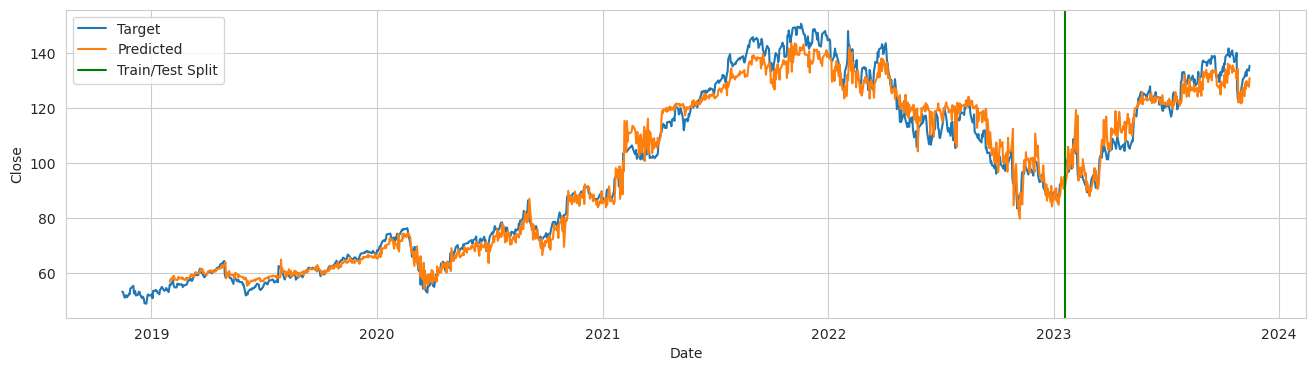

In [316]:
# Plot data
sns.set_style('whitegrid')
sns.set_palette('tab10')
fig, axes = plt.subplots(figsize=(16,4))
plot_x_all = stock_data[stock_name].index
plot_x_test = stock_data[stock_name][look_back:].index
sns.lineplot(x=plot_x_all, y=stock_data[stock_name][close_price_col_name], ax=axes, label='Target')
sns.lineplot(x=plot_x_test, y=pred_y.reshape(-1), ax=axes, label='Predicted')
plt.axvline(x=plot_x_test[n_train], c='green', label='Train/Test Split')
plt.legend()

In [317]:
trained_models[stock_name] = model

**Amazon stocks**

In [275]:
# Get data and model
stock_name = AMZN
dataset = datasets[stock_name]
model = models[stock_name]
model.to(device)

StockLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [281]:
# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) 

In [286]:
# Train model
train_model(model, optimizer, criterion, 6000, dataset, initial_epoch=4000)

Epoch 4000/6000 - loss:0.009626
Epoch 4100/6000 - loss:0.009153
Epoch 4200/6000 - loss:0.008938
Epoch 4300/6000 - loss:0.008789
Epoch 4400/6000 - loss:0.008575
Epoch 4500/6000 - loss:0.008273
Epoch 4600/6000 - loss:0.007946
Epoch 4700/6000 - loss:0.007694
Epoch 4800/6000 - loss:0.007589
Epoch 4900/6000 - loss:0.007654
Epoch 5000/6000 - loss:0.007861
Epoch 5100/6000 - loss:0.008171
Epoch 5200/6000 - loss:0.008540
Epoch 5300/6000 - loss:0.008932
Epoch 5400/6000 - loss:0.009312
Epoch 5500/6000 - loss:0.009646
Epoch 5600/6000 - loss:0.009886
Epoch 5700/6000 - loss:0.009973
Epoch 5800/6000 - loss:0.009847
Epoch 5900/6000 - loss:0.009457
Epoch 6000/6000 - loss:0.008795


In [287]:
# Get data from dataset
X_train, X_test, y_train, y_test = dataset

In [288]:
# Predict results
pred_x = np.vstack([X_train, X_test])
pred_y = scalers[stock_name].inverse_transform(model(torch.from_numpy(pred_x).to(device)).detach().cpu().numpy())

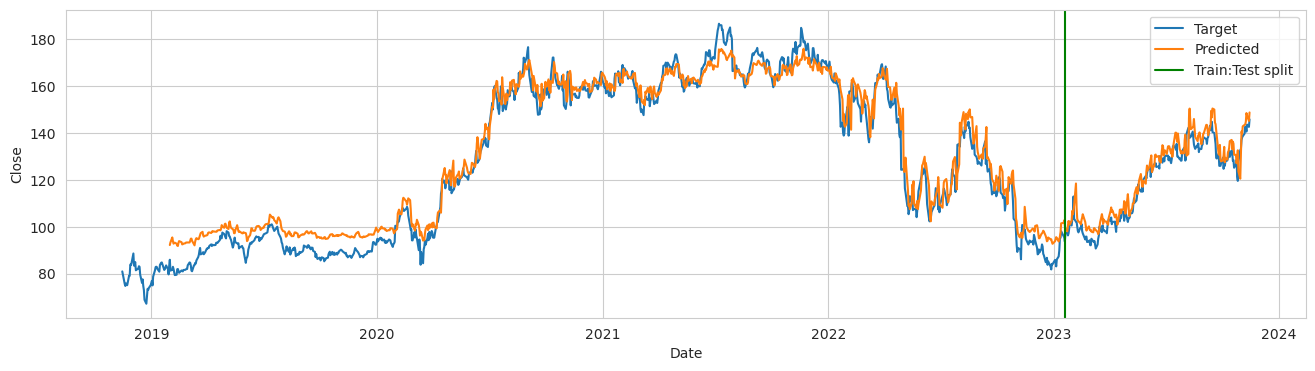

In [289]:
# Plot data
sns.set_style('whitegrid')
sns.set_palette('tab10')
fig, axes = plt.subplots(figsize=(16,4))
plot_x_all = stock_data[stock_name].index
plot_x_test = stock_data[stock_name][look_back:].index
sns.lineplot(x=plot_x_all, y=stock_data[stock_name][close_price_col_name], ax=axes, label='Target')
sns.lineplot(x=plot_x_test, y=pred_y.reshape(-1), ax=axes, label='Predicted')
plt.axvline(x=plot_x_test[n_train], c='green', label='Train:Test split')
plt.legend()

In [290]:
trained_models[stock_name] = model

**Microsoft stocks**

In [230]:
# Get data and model
stock_name = MSFT
dataset = datasets[stock_name]
model = models[stock_name]
model.to(device)

StockLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [242]:
# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) 

In [243]:
# Train model
train_model(model, optimizer, criterion, 3000, dataset, initial_epoch=2000)

Epoch 2000/3000 - loss:0.010442
Epoch 2100/3000 - loss:0.009177
Epoch 2200/3000 - loss:0.008039
Epoch 2300/3000 - loss:0.007203
Epoch 2400/3000 - loss:0.006656
Epoch 2500/3000 - loss:0.006266
Epoch 2600/3000 - loss:0.005875
Epoch 2700/3000 - loss:0.005377
Epoch 2800/3000 - loss:0.004799
Epoch 2900/3000 - loss:0.004294
Epoch 3000/3000 - loss:0.004035


In [244]:
# Get data from dataset
X_train, X_test, y_train, y_test = dataset

In [245]:
# Predict results
pred_x = np.vstack([X_train, X_test])
pred_y = scalers[stock_name].inverse_transform(model(torch.from_numpy(pred_x).to(device)).detach().cpu().numpy())

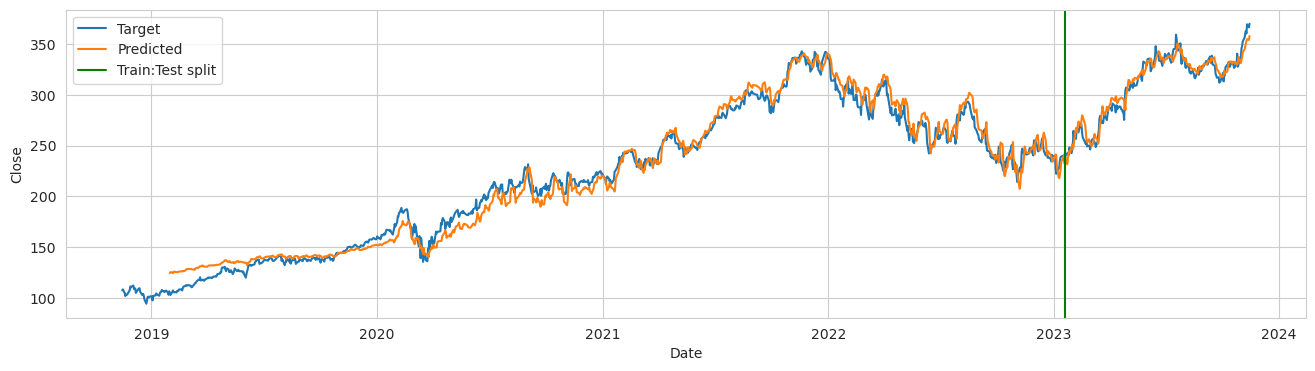

In [246]:
# Plot data
sns.set_style('whitegrid')
sns.set_palette('tab10')
fig, axes = plt.subplots(figsize=(16,4))
plot_x_all = stock_data[stock_name].index
plot_x_test = stock_data[stock_name][look_back:].index
sns.lineplot(x=plot_x_all, y=stock_data[stock_name][close_price_col_name], ax=axes, label='Target')
sns.lineplot(x=plot_x_test, y=pred_y.reshape(-1), ax=axes, label='Predicted')
plt.axvline(x=plot_x_test[n_train], c='green', label='Train:Test split')
plt.legend()

In [247]:
trained_models[stock_name] = model

**Meta stocks**

In [248]:
# Get data and model
stock_name = META
dataset = datasets[stock_name]
model = models[stock_name]
model.to(device)

StockLSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc_1): Linear(in_features=32, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [254]:
# Loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) 

In [255]:
# Train model
train_model(model, optimizer, criterion, 3000, dataset, initial_epoch=1000)

Epoch 1000/3000 - loss:0.012373
Epoch 1100/3000 - loss:0.012684
Epoch 1200/3000 - loss:0.012550
Epoch 1300/3000 - loss:0.011853
Epoch 1400/3000 - loss:0.010615
Epoch 1500/3000 - loss:0.009112
Epoch 1600/3000 - loss:0.007638
Epoch 1700/3000 - loss:0.006422
Epoch 1800/3000 - loss:0.005628
Epoch 1900/3000 - loss:0.005341
Epoch 2000/3000 - loss:0.005550
Epoch 2100/3000 - loss:0.006151
Epoch 2200/3000 - loss:0.006939
Epoch 2300/3000 - loss:0.007653
Epoch 2400/3000 - loss:0.008035
Epoch 2500/3000 - loss:0.007929
Epoch 2600/3000 - loss:0.007336
Epoch 2700/3000 - loss:0.006407
Epoch 2800/3000 - loss:0.005383
Epoch 2900/3000 - loss:0.004492
Epoch 3000/3000 - loss:0.003881


In [256]:
# Get data from dataset
X_train, X_test, y_train, y_test = dataset

In [257]:
# Predict results
pred_x = np.vstack([X_train, X_test])
pred_y = scalers[stock_name].inverse_transform(model(torch.from_numpy(pred_x).to(device)).detach().cpu().numpy())

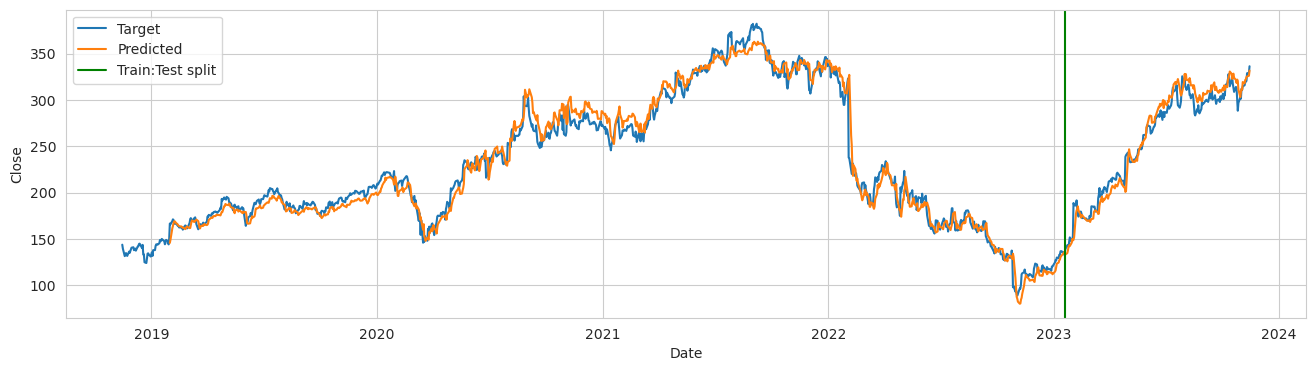

In [258]:
# Plot data
sns.set_style('whitegrid')
sns.set_palette('tab10')
fig, axes = plt.subplots(figsize=(16,4))
plot_x_all = stock_data[stock_name].index
plot_x_test = stock_data[stock_name][look_back:].index
sns.lineplot(x=plot_x_all, y=stock_data[stock_name][close_price_col_name], ax=axes, label='Target')
sns.lineplot(x=plot_x_test, y=pred_y.reshape(-1), ax=axes, label='Predicted')
plt.axvline(x=plot_x_test[n_train], c='green', label='Train:Test split')
plt.legend()

In [259]:
trained_models[stock_name] = model

#### All results

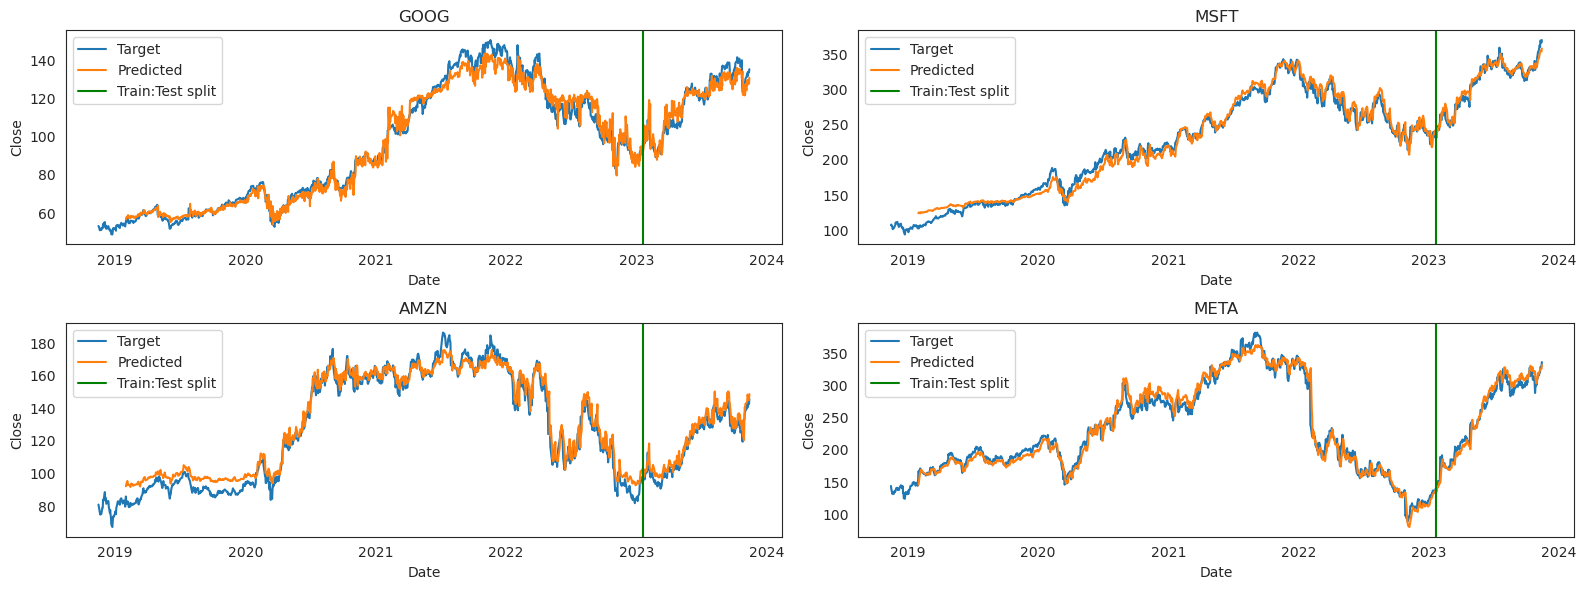

In [318]:
# Loop all stocks to generate combined graph
sns.set_style('white')
fig, axes = plt.subplots(2,2,figsize=(16, 6))
for i, stock_name in enumerate(stock_list):
    ax = axes[i//2, i%2]
    X_train, X_test, y_train, y_test = datasets[stock_name]
    pred_x = np.vstack([X_train, X_test])
    pred_y = scalers[stock_name].inverse_transform(trained_models[stock_name](torch.from_numpy(pred_x).to(device)).detach().cpu().numpy())
    plot_x_all = stock_data[stock_name].index
    plot_x_test = stock_data[stock_name][look_back:].index
    sns.lineplot(x=plot_x_all, y=stock_data[stock_name][close_price_col_name], label='Target', ax=ax)
    sns.lineplot(x=plot_x_test, y=pred_y.reshape(-1), label='Predicted', ax=ax)
    ax.axvline(x=plot_x_test[n_train], c='green', label='Train:Test split')
    ax.legend()
    ax.set_title(stock_name)
plt.tight_layout()
plt.show()

#### Save models

In [319]:
# Save all models
for stock_name in stock_list:
    torch.save(trained_models[stock_name], f'{stock_name}_model.pt')